In [132]:
import time
from copy import deepcopy
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import numpy as np
from matplotlib import pyplot
np.random.seed(2017) # set random seed value to get reproducible results

In [133]:
# store start time to get execution time of entire script
import time
start_time = time.time()

In [134]:
df = pd.read_csv('data_cleaned.csv', index_col=[0])
df.drop(columns=['ada_0_cd'], inplace=True) # temporary!!!

print(df.shape)
df.head()

(5457, 39)


,engage30,init,female_cd,nonwhite_cd,unemplmt_cd,primsev_cd,prsatx_cd,TRIg_0_cd,TMIg_0_cd,SESg_0_cd,...,SFSg_0_cd,Raceg4_cd_1,Raceg4_cd_2,Raceg4_cd_3,Raceg4_cd_4,loc_cd_1,loc_cd_2,loc_cd_3,loc_cd_6,loc_cd_9
0,1,1,0,0,1,2,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0
4,1,1,0,0,0,2,0,1,1,0,...,1,1,0,0,0,1,0,0,0,0
9,0,1,0,0,0,2,0,0,2,0,...,0,1,0,0,0,1,0,0,0,0
11,1,1,0,0,0,2,0,1,1,0,...,0,1,0,0,0,1,0,0,0,0
16,1,1,0,0,0,2,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0


In [135]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

def bidirectional_feature_importance(X, y, verbose=False):
    X_train_init, X_test, y_train_init, y_test = train_test_split(X, y, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_train_init, y_train_init, test_size=0.2)

    sfs_y = [] # SFS is performed from the empty set
    sbs_y = list(X_train.columns) # SBS is performed from the full set
    
    stats_x = []
    stats_y = []
    
    top_score = 0
    top_feature_set = []

    while len(sbs_y) != len(sfs_y): # repeat until convergence
        if verbose:
            print('sfs_y:', sfs_y)
            print('sbs_y:', sbs_y)
        
        # Select the best feature
        best_feat_score = 0
        best_feat = ''
        for feat in sbs_y: # Features already removed by SBS cannot be added by SFS
            if feat not in sfs_y: # Ignore already added features
                sfs_y.append(feat)

                local_X_train = X_train[sfs_y]
                model = LogisticRegressionCV(cv=5, max_iter=1000)
                model.fit(local_X_train, y_train)

                local_X_val = X_val[sfs_y]
                lr_probs = model.predict_proba(local_X_val)
                lr_probs = lr_probs[:, 1] # keep probabilities for the positive outcome only
                lr_auc = roc_auc_score(y_val, lr_probs) # calculate scores
                if lr_auc > best_feat_score:
                    best_feat_score = lr_auc
                    best_feat = feat

                sfs_y.pop()
                
        if verbose:
            print('adding', best_feat)
        sfs_y.append(best_feat)
        
        # Remove the worst feature
        worst_feat_score = 1
        worst_feat = ''
        for feat in sbs_y: # Ignore already removed features
            if feat not in sfs_y: # Features already selected by SFS cannot be removed by SBS
                sbs_y.remove(feat)

                local_X_train = X_train[sbs_y]
                model = LogisticRegressionCV(cv=5, max_iter=1000)
                model.fit(local_X_train, y_train)

                local_X_val = X_val[sbs_y]
                lr_probs = model.predict_proba(local_X_val)
                lr_probs = lr_probs[:, 1] # keep probabilities for the positive outcome only
                lr_auc = roc_auc_score(y_val, lr_probs) # calculate scores 
                if lr_auc <= worst_feat_score:
                    worst_feat_score = lr_auc
                    worst_feat = feat

                sbs_y.append(feat)
                
        if verbose:
            print('removing', worst_feat)
        sbs_y.remove(worst_feat)
        
        # for overall performance plot
        model = LogisticRegressionCV(cv=5, max_iter=1000)
        local_X_train_init = X_train_init[sbs_y]
        model.fit(local_X_train_init, y_train_init)

        local_X_test = X_test[sbs_y]
        lr_probs = model.predict_proba(local_X_test)
        lr_probs = lr_probs[:, 1] # keep probabilities for the positive outcome only
        lr_auc = roc_auc_score(y_test, lr_probs) # calculate scores 

        if verbose:
            print('saving stats for:', sbs_y)
            print('len =', len(sbs_y))
            print('score =', lr_auc)
        stats_x.append(len(sbs_y))
        stats_y.append(lr_auc)
        
        if lr_auc > top_score:
            if verbose:
                print('new top score!', lr_auc, '>', top_score)
            top_score = lr_auc
            top_feature_set = deepcopy(sbs_y)
    
    plt.plot(stats_x, stats_y)
    plt.xlabel('# of features')
    plt.ylabel('AUC')
    plt.show()
        
    if verbose:
        print('sfs_y final:', sfs_y)
        print('sbs_y final:', sbs_y)
    
    print('optimal # of features:', len(top_feature_set))
    print('optimal features:', top_feature_set)
    return top_feature_set

In [136]:
def run_model(model, data, grouping, outcome):
    X = data.drop(columns=[outcome])
    y = data[outcome]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    print("X_train:", X_train.shape, "X_test:", X_test.shape, "y_train:", y_train.shape, "y_test:", y_test.shape)    
    
    res = cross_validate(model, X_train, y_train, return_estimator=True, cv=5)
    top_model_ind = list(res['test_score']).index(max(list(res['test_score'])))
    model = res['estimator'][top_model_ind]
    
    y_pred = model.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)

    # https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9
    print("Accuracy:", accuracy)
    print("F1:", f1)
    print("Precision:", precision)
    print("Recall:", recall)
    
    try:
        # random forest
        feature_importance = model.feature_importances_ 
        label = "RF " + grouping + " " + outcome
    except AttributeError:
        # logistic regression
        feature_importance = np.exp(model.coef_[0]) # hazard ratios
        label = "LR " + grouping + " " + outcome
    
    ns_probs = [0 for _ in range(len(y_test))]
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    lr_auc = metrics.roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('AUC: %.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.title(label)
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    
    features = X.columns
    feature_importance_df = pd.DataFrame({"feature": features, label: feature_importance})
    feature_importance_df = feature_importance_df.set_index('feature')
    return feature_importance_df

In [137]:
def get_logistic_regression_features(X):
    # one-hot encode all variables (except binary vars) to get hazards across groups, drop reference group
    result = X.copy()
    outcomes = ["init", "engage30", "ada_0_cd"] # temporarily ignore ada_0_cd
    
    for col in result.columns:
        if not np.isin(result[col], [0, 1]).all() and col not in outcomes: # if non-binary and not an outcome
            one_hot = pd.get_dummies(result[col], prefix=col)
            one_hot = one_hot.loc[:, ~one_hot.columns.str.endswith('1')] # drop group and use as reference
            result = result.drop(col,axis = 1)
            result = result.join(one_hot)
    #print('Logistic Regression Features:',lasso_X.columns)
    return result

In [138]:
opioids_mask = df['primsev_cd'] == 5
opioids = df[opioids_mask]
opioids = opioids.drop(columns=['primsev_cd'])

amphetamines_mask = df['primsev_cd'] == 2
cocaine_mask = df['primsev_cd'] == 4
stimulants = df[amphetamines_mask | cocaine_mask]
stimulants = stimulants.drop(columns=['primsev_cd'])

print('Opioids:', opioids.shape)
print('Stimulants:', stimulants.shape)

Opioids: (933, 38)
Stimulants: (4524, 38)


In [139]:
opioids_engage30 = opioids.drop(columns=['init'])
opioids_init = opioids.drop(columns=['engage30'])
stimulants_engage30 = stimulants.drop(columns=['init'])
stimulants_init = stimulants.drop(columns=['engage30'])

In [140]:
# initialize feature importance dataframes

features_random_forest = list(opioids_engage30.columns)
features_random_forest.remove('engage30')
feature_importance_random_forest = pd.DataFrame({"feature": features_random_forest})
feature_importance_random_forest = feature_importance_random_forest.set_index('feature')


features_logistic_regression = list(get_logistic_regression_features(opioids_engage30).columns)
features_logistic_regression.remove('engage30')
feature_importance_logistic_regression = pd.DataFrame({"feature": features_logistic_regression})
feature_importance_logistic_regression = feature_importance_logistic_regression.set_index('feature')

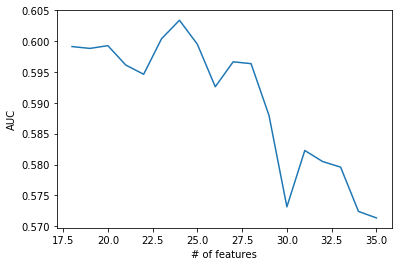

optimal # of features: 24
optimal features: ['female_cd', 'SFSg_0_cd', 'loc_cd_3', 'loc_cd_1', 'prsatx_cd', 'epsg_0_cd', 'und15_cd', 'loc_cd_9', 'homeless_0_cd', 'gvsg_cd', 'loc_cd_2', 'dldiag_cd', 'gcsg_0_cd', 'suicprbs_0_cd', 'S6_cd', 'Raceg4_cd_1', 'dssg_0_cd', 'Raceg4_cd_4', 'ncar_cd', 'CWSg_0_cd', 'lrig_0_cd', 'S9y10_cd', 'adhdg_0_cd', 'nonwhite_cd']
CPU times: user 6min 27s, sys: 23.5 s, total: 6min 50s
Wall time: 3min 50s


In [141]:
%%time

X = opioids_engage30.drop(columns=['engage30'])
y = opioids_engage30['engage30']
features_opioids_engage30 = bidirectional_feature_importance(X, y)

In [142]:
features_opioids_engage30.append('engage30')
features_opioids_engage30

['female_cd',
 'SFSg_0_cd',
 'loc_cd_3',
 'loc_cd_1',
 'prsatx_cd',
 'epsg_0_cd',
 'und15_cd',
 'loc_cd_9',
 'homeless_0_cd',
 'gvsg_cd',
 'loc_cd_2',
 'dldiag_cd',
 'gcsg_0_cd',
 'suicprbs_0_cd',
 'S6_cd',
 'Raceg4_cd_1',
 'dssg_0_cd',
 'Raceg4_cd_4',
 'ncar_cd',
 'CWSg_0_cd',
 'lrig_0_cd',
 'S9y10_cd',
 'adhdg_0_cd',
 'nonwhite_cd',
 'engage30']

X_train: (625, 24) X_test: (308, 24) y_train: (625,) y_test: (308,)
Accuracy: 0.6915584415584416
F1: 0.8065173116089613
Precision: 0.7279411764705882
Recall: 0.9041095890410958
AUC: 0.564


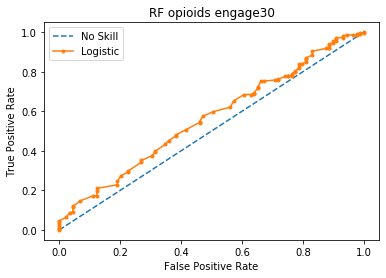

In [143]:
random_forest_opioids_engage30 = run_model(RandomForestClassifier(), opioids_engage30[features_opioids_engage30], 'opioids', 'engage30')
feature_importance_random_forest = feature_importance_random_forest.join(random_forest_opioids_engage30)

X_train: (625, 33) X_test: (308, 33) y_train: (625,) y_test: (308,)
Accuracy: 0.6883116883116883
F1: 0.8040816326530612
Precision: 0.7378277153558053
Recall: 0.8834080717488789
AUC: 0.568


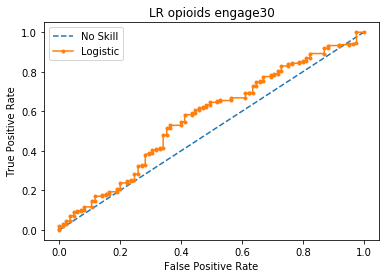

In [144]:
opioids_engage30_logistic_regression = get_logistic_regression_features(opioids_engage30[features_opioids_engage30])

logistic_regression_opioids_engage30 = run_model(LogisticRegression(max_iter=1000), opioids_engage30_logistic_regression, 'opioids', 'engage30')
feature_importance_logistic_regression = feature_importance_logistic_regression.join(logistic_regression_opioids_engage30)

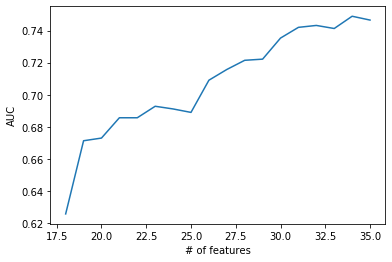

optimal # of features: 34
optimal features: ['prsatx_cd', 'gvsg_cd', 'srprobg_cd', 'epsg_0_cd', 'cdsg_0_cd', 'srig_0_cd', 'ncar_cd', 'Raceg4_cd_3', 'loc_cd_3', 'unemplmt_cd', 'CWSg_0_cd', 'suicprbs_0_cd', 'SFSg_0_cd', 'loc_cd_6', 'S9y10_cd', 'Raceg4_cd_2', 'adhdg_0_cd', 'tsd_0_cd', 'TMIg_0_cd', 'dldiag_cd', 'S6_cd', 'loc_cd_1', 'SESg_0_cd', 'homeless_0_cd', 'female_cd', 'nonwhite_cd', 'cjsig_0_cd', 'loc_cd_9', 'Raceg4_cd_4', 'loc_cd_2', 'Raceg4_cd_1', 'lrig_0_cd', 'dssg_0_cd', 'und15_cd']
CPU times: user 8min 48s, sys: 34.1 s, total: 9min 22s
Wall time: 5min 14s


In [145]:
%%time

X = opioids_init.drop(columns=['init'])
y = opioids_init['init']
features_opioids_init = bidirectional_feature_importance(X, y)

In [146]:
features_opioids_init.append('init')
features_opioids_init

['prsatx_cd',
 'gvsg_cd',
 'srprobg_cd',
 'epsg_0_cd',
 'cdsg_0_cd',
 'srig_0_cd',
 'ncar_cd',
 'Raceg4_cd_3',
 'loc_cd_3',
 'unemplmt_cd',
 'CWSg_0_cd',
 'suicprbs_0_cd',
 'SFSg_0_cd',
 'loc_cd_6',
 'S9y10_cd',
 'Raceg4_cd_2',
 'adhdg_0_cd',
 'tsd_0_cd',
 'TMIg_0_cd',
 'dldiag_cd',
 'S6_cd',
 'loc_cd_1',
 'SESg_0_cd',
 'homeless_0_cd',
 'female_cd',
 'nonwhite_cd',
 'cjsig_0_cd',
 'loc_cd_9',
 'Raceg4_cd_4',
 'loc_cd_2',
 'Raceg4_cd_1',
 'lrig_0_cd',
 'dssg_0_cd',
 'und15_cd',
 'init']

X_train: (625, 34) X_test: (308, 34) y_train: (625,) y_test: (308,)
Accuracy: 0.9123376623376623
F1: 0.9538461538461538
Precision: 0.9147540983606557
Recall: 0.9964285714285714
AUC: 0.655


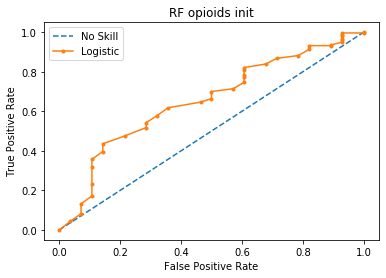

In [147]:
random_forest_opioids_init = run_model(RandomForestClassifier(), opioids_init[features_opioids_init], 'opioids', 'init')
feature_importance_random_forest = feature_importance_random_forest.join(random_forest_opioids_init)

X_train: (625, 48) X_test: (308, 48) y_train: (625,) y_test: (308,)
Accuracy: 0.8766233766233766
F1: 0.9342560553633218
Precision: 0.8823529411764706
Recall: 0.9926470588235294
AUC: 0.693


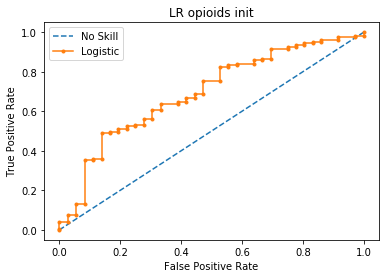

In [148]:
opioids_init_logistic_regression = get_logistic_regression_features(opioids_init[features_opioids_init])

logistic_regression_opioids_init = run_model(LogisticRegression(max_iter=1000), opioids_init_logistic_regression, 'opioids', 'init')
feature_importance_logistic_regression = feature_importance_logistic_regression.join(logistic_regression_opioids_init)

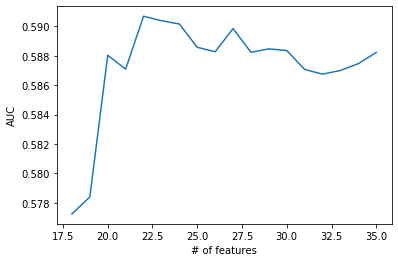

optimal # of features: 22
optimal features: ['gvsg_cd', 'cdsg_0_cd', 'loc_cd_6', 'SFSg_0_cd', 'loc_cd_9', 'SESg_0_cd', 'loc_cd_2', 'suicprbs_0_cd', 'TMIg_0_cd', 'epsg_0_cd', 'S9y10_cd', 'gcsg_0_cd', 'ncar_cd', 'Raceg4_cd_4', 'srig_0_cd', 'female_cd', 'homeless_0_cd', 'lrig_0_cd', 'tsd_0_cd', 'loc_cd_1', 'S6_cd', 'Raceg4_cd_1']
CPU times: user 6min 35s, sys: 23.5 s, total: 6min 59s
Wall time: 3min 36s


In [149]:
%%time

X = stimulants_engage30.drop(columns=['engage30'])
y = stimulants_engage30['engage30']
features_stimulants_engage30 = bidirectional_feature_importance(X, y)

In [150]:
features_stimulants_engage30.append('engage30')
features_stimulants_engage30

['gvsg_cd',
 'cdsg_0_cd',
 'loc_cd_6',
 'SFSg_0_cd',
 'loc_cd_9',
 'SESg_0_cd',
 'loc_cd_2',
 'suicprbs_0_cd',
 'TMIg_0_cd',
 'epsg_0_cd',
 'S9y10_cd',
 'gcsg_0_cd',
 'ncar_cd',
 'Raceg4_cd_4',
 'srig_0_cd',
 'female_cd',
 'homeless_0_cd',
 'lrig_0_cd',
 'tsd_0_cd',
 'loc_cd_1',
 'S6_cd',
 'Raceg4_cd_1',
 'engage30']

X_train: (3031, 22) X_test: (1493, 22) y_train: (3031,) y_test: (1493,)
Accuracy: 0.6202277294038848
F1: 0.7354176388240784
Precision: 0.6740804106073567
Recall: 0.8090349075975359
AUC: 0.563


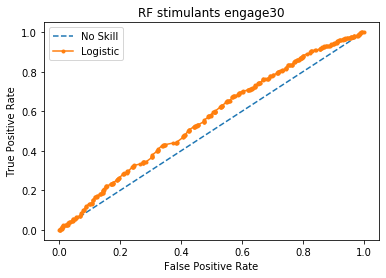

In [151]:
random_forest_stimulants_engage30 = run_model(RandomForestClassifier(), stimulants_engage30[features_stimulants_engage30], 'stimulants', 'engage30')
feature_importance_random_forest = feature_importance_random_forest.join(random_forest_stimulants_engage30)

X_train: (3031, 32) X_test: (1493, 32) y_train: (3031,) y_test: (1493,)
Accuracy: 0.6329537843268587
F1: 0.7557932263814616
Precision: 0.648814078041316
Recall: 0.9050160085378869
AUC: 0.594


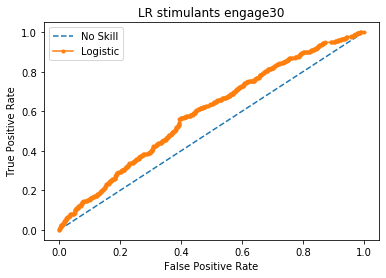

In [152]:
stimulants_engage30_logistic_regression = get_logistic_regression_features(stimulants_engage30[features_stimulants_engage30])

logistic_regression_stimulants_engage30 = run_model(LogisticRegression(max_iter=1000), stimulants_engage30_logistic_regression, 'stimulants', 'engage30')
feature_importance_logistic_regression = feature_importance_logistic_regression.join(logistic_regression_stimulants_engage30)

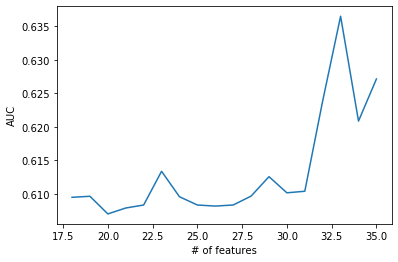

optimal # of features: 33
optimal features: ['gvsg_cd', 'dldiag_cd', 'epsg_0_cd', 'S6_cd', 'loc_cd_1', 'SESg_0_cd', 'homeless_0_cd', 'TRIg_0_cd', 'female_cd', 'nonwhite_cd', 'srig_0_cd', 'unemplmt_cd', 'loc_cd_6', 'tsd_0_cd', 'SFSg_0_cd', 'ncar_cd', 'CWSg_0_cd', 'prsatx_cd', 'cjsig_0_cd', 'loc_cd_9', 'Raceg4_cd_4', 'gcsg_0_cd', 'Raceg4_cd_3', 'Raceg4_cd_2', 'loc_cd_2', 'TMIg_0_cd', 'Raceg4_cd_1', 'lrig_0_cd', 'suicprbs_0_cd', 'dssg_0_cd', 'loc_cd_3', 'und15_cd', 'srprobg_cd']
CPU times: user 6min 23s, sys: 23.1 s, total: 6min 46s
Wall time: 3min 32s


In [153]:
%%time

X = stimulants_init.drop(columns=['init'])
y = stimulants_init['init']
features_stimulants_init = bidirectional_feature_importance(X, y)

In [154]:
features_stimulants_init.append('init')
features_stimulants_init

['gvsg_cd',
 'dldiag_cd',
 'epsg_0_cd',
 'S6_cd',
 'loc_cd_1',
 'SESg_0_cd',
 'homeless_0_cd',
 'TRIg_0_cd',
 'female_cd',
 'nonwhite_cd',
 'srig_0_cd',
 'unemplmt_cd',
 'loc_cd_6',
 'tsd_0_cd',
 'SFSg_0_cd',
 'ncar_cd',
 'CWSg_0_cd',
 'prsatx_cd',
 'cjsig_0_cd',
 'loc_cd_9',
 'Raceg4_cd_4',
 'gcsg_0_cd',
 'Raceg4_cd_3',
 'Raceg4_cd_2',
 'loc_cd_2',
 'TMIg_0_cd',
 'Raceg4_cd_1',
 'lrig_0_cd',
 'suicprbs_0_cd',
 'dssg_0_cd',
 'loc_cd_3',
 'und15_cd',
 'srprobg_cd',
 'init']

X_train: (3031, 33) X_test: (1493, 33) y_train: (3031,) y_test: (1493,)
Accuracy: 0.87073007367716
F1: 0.9307995697382575
Precision: 0.8740740740740741
Recall: 0.995398773006135
AUC: 0.667


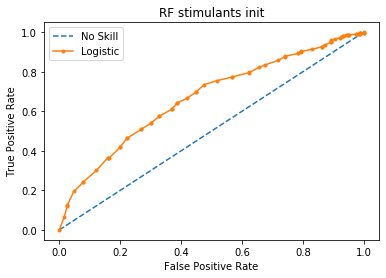

In [155]:
random_forest_stimulants_init = run_model(RandomForestClassifier(), stimulants_init[features_stimulants_init], 'stimulants', 'init')
feature_importance_random_forest = feature_importance_random_forest.join(random_forest_stimulants_init)

X_train: (3031, 46) X_test: (1493, 46) y_train: (3031,) y_test: (1493,)
Accuracy: 0.8921634293369055
F1: 0.9430088495575221
Precision: 0.8921634293369055
Recall: 1.0
AUC: 0.662


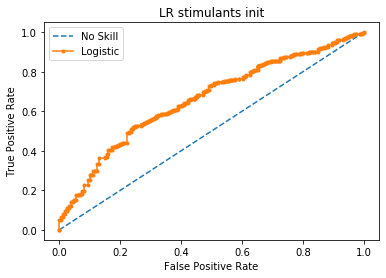

In [156]:
stimulants_init_logistic_regression = get_logistic_regression_features(stimulants_init[features_stimulants_init])

logistic_regression_stimulants_init = run_model(LogisticRegression(max_iter=1000), stimulants_init_logistic_regression, 'stimulants', 'init')
feature_importance_logistic_regression = feature_importance_logistic_regression.join(logistic_regression_stimulants_init)

In [157]:
total_seconds = int(time.time() - start_time)
hours = total_seconds // (60 * 60)
minutes = (total_seconds - hours*60) // 60
seconds = (total_seconds - hours*60) % 60
print("--- " + str(minutes) + " minutes " + str(seconds) + " seconds ---")

--- 16 minutes 22 seconds ---
